In [1]:
# Install the necessary libraries
!pip install scikit-learn matplotlib seaborn imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

In [4]:
# Upload the dataset into Google Colab and load it
df = pd.read_csv('/content/onlinefraud.csv')

# Explore the first few rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [5]:
# Split the dataset into features (X) and target (y)
print(df.columns)


X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


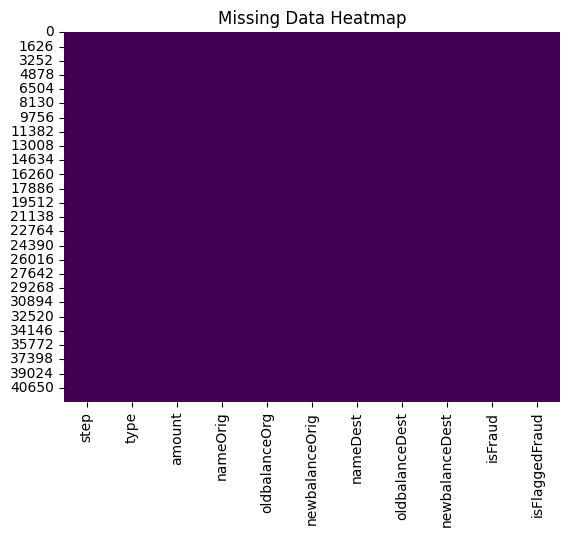

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [6]:
# Check for missing values
print(df.isnull().sum())

# Plot missing data
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# Select only numeric columns for median imputation
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Verify if missing values are handled
print(df.isnull().sum())

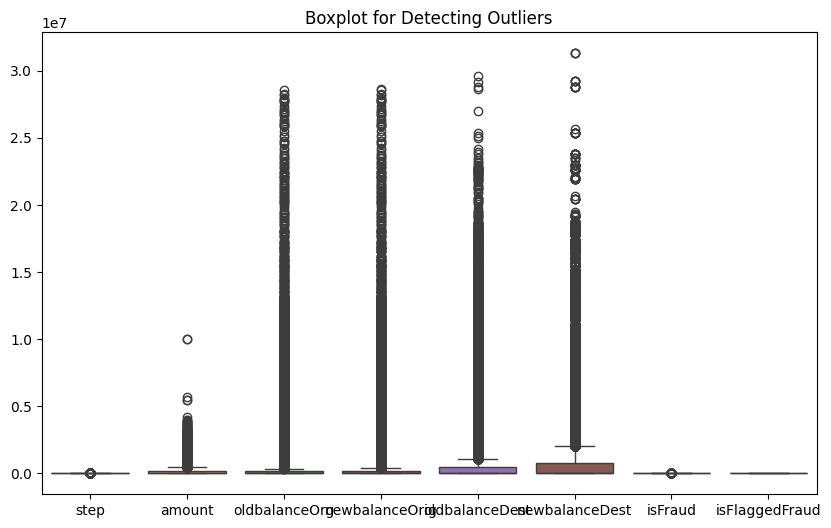

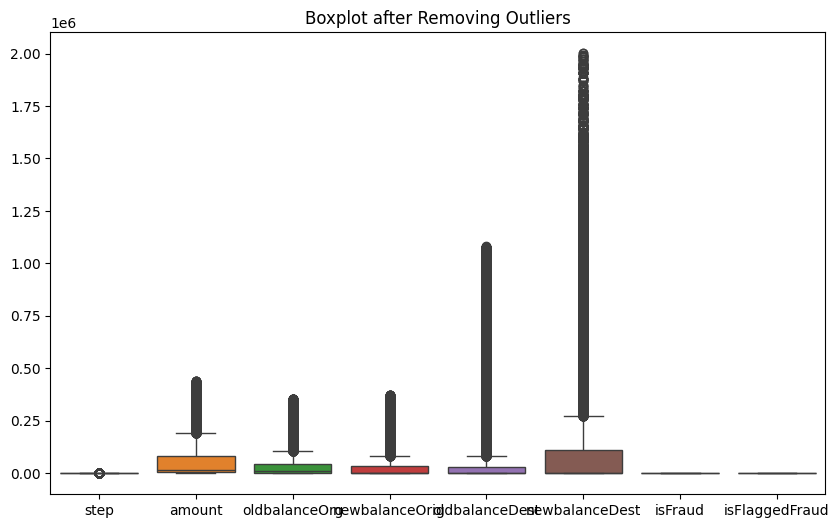

In [7]:
# Identify outliers using boxplot
plt.figure(figsize=(10, 6))
# Select only numeric features for the boxplot
numeric_df = df.select_dtypes(include=np.number)
sns.boxplot(data=numeric_df)
plt.title('Boxplot for Detecting Outliers')
plt.show()

# Handling Outliers (Example: Removing outliers based on the IQR method)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1


df_filtered = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]


plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered.select_dtypes(include=np.number))
plt.title('Boxplot after Removing Outliers')
plt.show()

Number of duplicate rows: 0


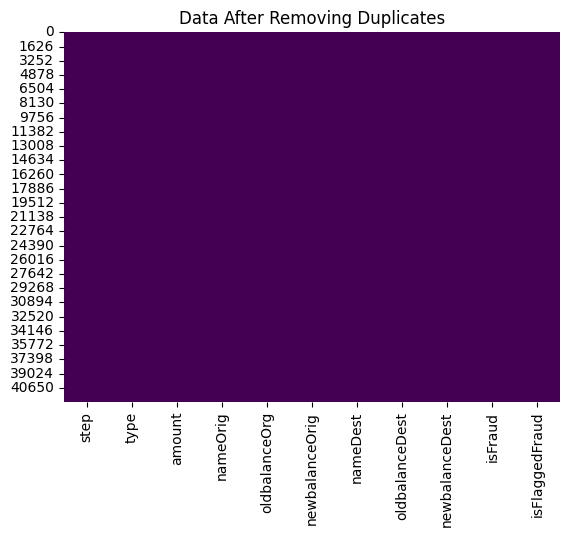

In [8]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates
df_cleaned = df.drop_duplicates()

# Plot after cleaning duplicates
sns.heatmap(df_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Data After Removing Duplicates')
plt.show()



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import gc

# Function to downcast numeric columns and handle errors explicitly
def downcast(df):
    for col in df.select_dtypes(include=['int', 'float']).columns:
        try:
            df[col] = pd.to_numeric(df[col], downcast='integer')
        except Exception as e:
            print(f"Could not downcast {col}: {e}")

        try:
            df[col] = pd.to_numeric(df[col], downcast='float')
        except Exception as e:
            print(f"Could not downcast {col}: {e}")
    return df

# Load data in chunks and process each chunk
chunk_size = 100000  # Adjust the chunk size based on memory capacity
chunks = pd.read_csv('/content/onlinefraud.csv', chunksize=chunk_size)

# Process each chunk
for chunk in chunks:
    # Downcast the numeric columns
    chunk = downcast(chunk)

    # Drop non-essential columns
    chunk = chunk.drop(['nameOrig', 'nameDest'], axis=1)

    # Split the dataset into features (X) and target (y)
    X = chunk.drop('isFraud', axis=1)
    y = chunk['isFraud']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform label encoding on categorical columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    encoder = LabelEncoder()
    for col in categorical_cols:
        X_train[col] = encoder.fit_transform(X_train[col])
        X_test[col] = encoder.transform(X_test[col])

    # Feature Scaling using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)


    del chunk
    gc.collect()


<ipython-input-10-e7bf6704a9c0>:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], downcast='integer', errors='ignore')
<ipython-input-10-e7bf6704a9c0>:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], downcast='float', errors='ignore')
<ipython-input-10-e7bf6704a9c0>:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], downcast='integer', errors='ignore')
<ipython-input-10-e7bf6704a9c0>:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instea

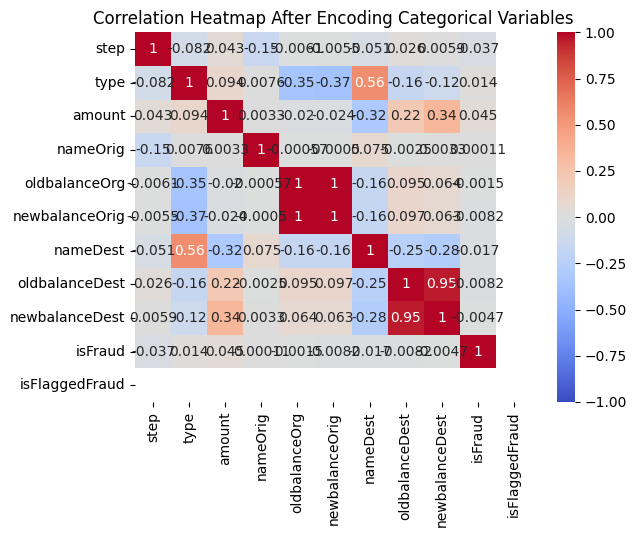

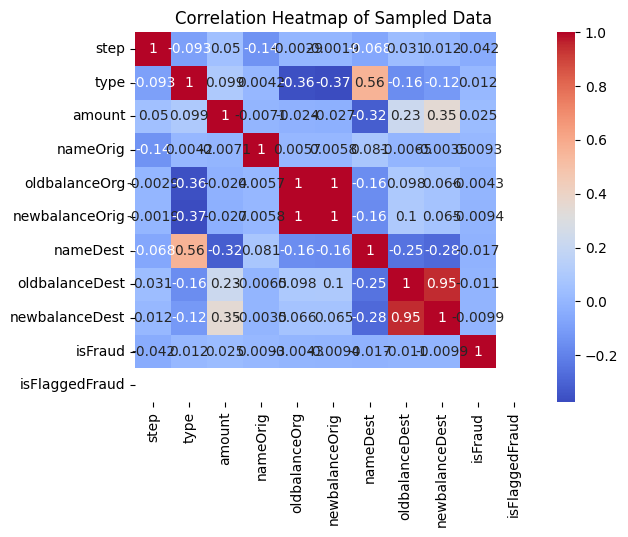

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

# Function to downcast numeric columns to save memory
def downcast(df):
    for col in df.select_dtypes(include=['int', 'float']).columns:
        try:
            df[col] = pd.to_numeric(df[col], downcast='integer', errors='ignore')
        except Exception as e:
            print(f"Could not downcast {col}: {e}")
        try:
            df[col] = pd.to_numeric(df[col], downcast='float', errors='ignore')
        except Exception as e:
            print(f"Could not downcast {col}: {e}")
    return df

# Define chunk size
chunk_size = 100000
chunks = []


for chunk in pd.read_csv('/content/onlinefraud.csv', chunksize=chunk_size):
    # Downcast numeric columns to reduce memory usage
    chunk = downcast(chunk)

    # Convert categorical columns to 'category' dtype to save memory
    for col in chunk.select_dtypes(include=['object']).columns:
        chunk[col] = chunk[col].astype('category')

    # Apply Label Encoding to categorical columns
    encoder = LabelEncoder()
    for col in chunk.select_dtypes(include=['category']).columns:
        chunk[col] = encoder.fit_transform(chunk[col])

    # Append the processed chunk (as a sparse matrix to save memory)
    chunks.append(chunk)

# Concatenate all chunks into one DataFrame
df = pd.concat(chunks, axis=0)

# Perform one-hot encoding with sparse matrix to save memory
df_encoded = pd.get_dummies(df, drop_first=True, sparse=True)

# Visualize the correlation heatmap of the encoded data (for smaller sample)
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap After Encoding Categorical Variables')
plt.show()


df_sample = df_encoded.sample(frac=0.05, random_state=42)
sns.heatmap(df_sample.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Sampled Data')
plt.show()


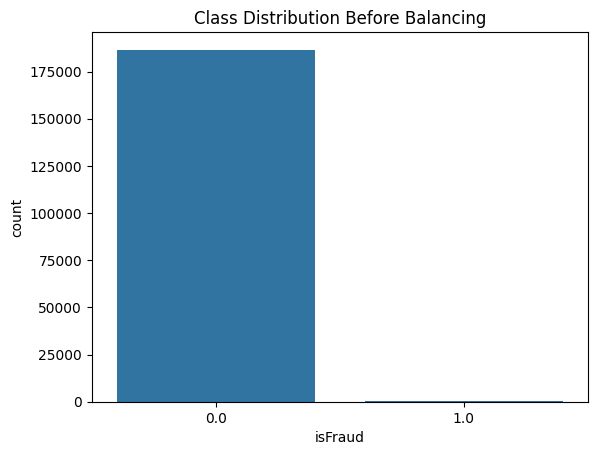

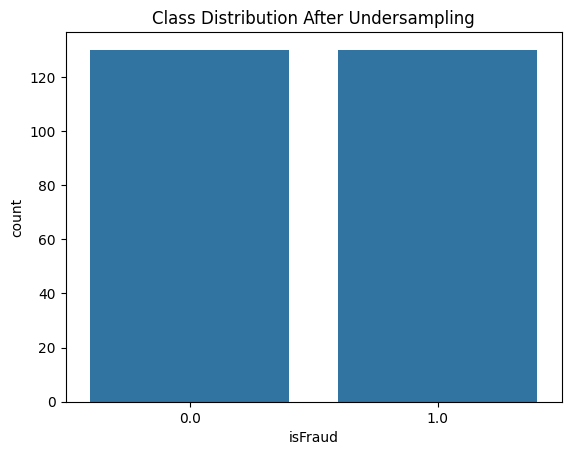

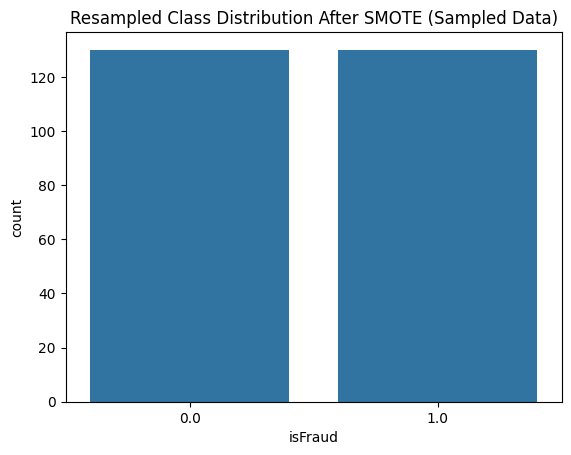

Original class distribution: isFraud
0.0    186582
1.0       130
Name: count, dtype: int64
Class distribution after Undersampling: isFraud
0.0    130
1.0    130
Name: count, dtype: int64
Class distribution after SMOTE: isFraud
0.0    130
1.0    130
Name: count, dtype: int64


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


df = pd.read_csv('/content/onlinefraud.csv')

# Check for missing values and drop rows with missing target variable
df.dropna(subset=['isFraud'], inplace=True)

# Define target (y) and features (X)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Apply Label Encoding for categorical columns
encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply scaling to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Visualize class distribution before any balancing
sns.countplot(x=y_train)
plt.title('Class Distribution Before Balancing')
plt.show()

# Undersample the majority class to balance the classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y_train)

# Visualize class distribution after undersampling
sns.countplot(x=y_resampled)
plt.title('Class Distribution After Undersampling')
plt.show()

# Apply SMOTE to balance the classes further (if needed)
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_resampled, y_resampled)

# Visualize resampled class distribution after SMOTE
sns.countplot(x=y_resampled_smote[:1000])
plt.title('Resampled Class Distribution After SMOTE (Sampled Data)')
plt.show()

print(f'Original class distribution: {y_train.value_counts()}')
print(f'Class distribution after Undersampling: {pd.Series(y_resampled).value_counts()}')
print(f'Class distribution after SMOTE: {pd.Series(y_resampled_smote).value_counts()}')


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('select_k_best', SelectKBest(score_func=f_classif, k='all')),  # Feature selection
    ('classifier', LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000))  # Logistic Regression
])

In [13]:

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Random Forest pipeline
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('select_k_best', SelectKBest(score_func=f_classif, k='all')),  # Feature selection
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Random Forest Classifier
])

In [14]:
# Define hyperparameter grid for Logistic Regression
param_grid_lr = {
    'select_k_best__k': [5, 10, 'all'],  # Feature selection
    'classifier__C': [0.1, 1, 10],  # Regularization strength
    'classifier__max_iter': [500, 1000]  # Max iterations
}

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'select_k_best__k': [5, 10, 'all'],
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [10, 20, None]  # Max depth of trees
}

# Grid Search for Logistic Regression
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, n_jobs=-1, verbose=1)
grid_search_lr.fit(X_resampled, y_resampled)

# Grid Search for Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select_k_best', SelectKBest(k='all')),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__n_estimators': [50, 100, 200],
                         'select_k_best__k': [5, 10, 'all']},
             verbose=1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Logistic Regression Accuracy: 0.9353242357376979


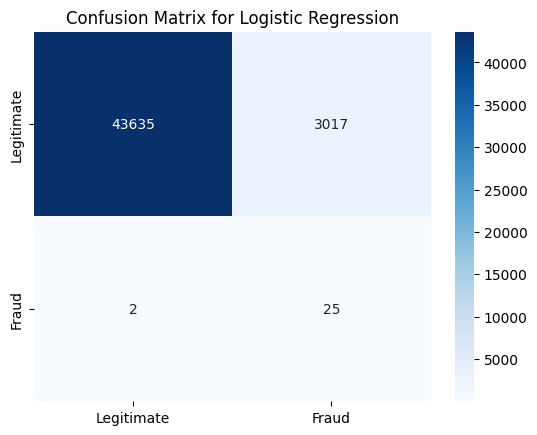

In [15]:

from sklearn.metrics import accuracy_score, confusion_matrix

# Best Model for Logistic Regression
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


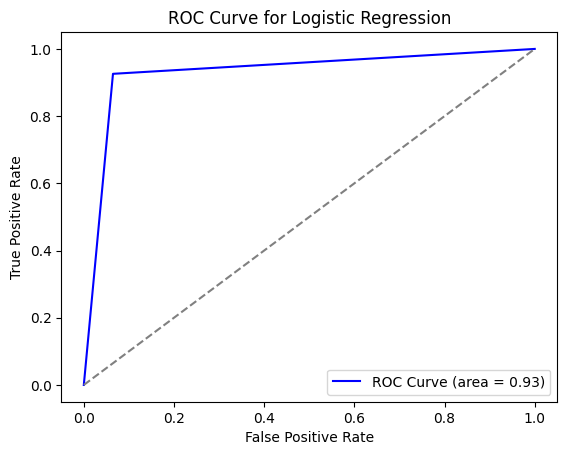

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, best_lr.predict_proba(X_test)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='blue', label=f'ROC Curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Random Forest Accuracy: 0.999421581439191


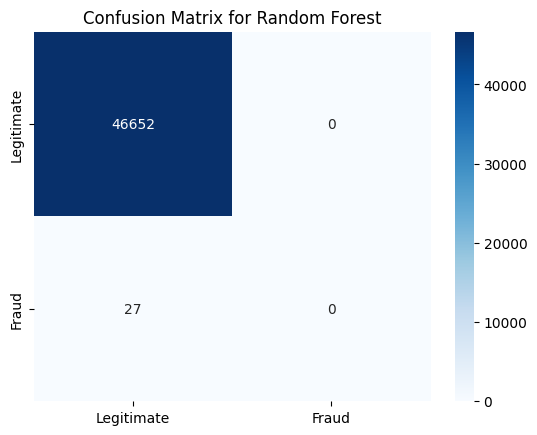

In [17]:
# Best Model for Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix for Random Forest')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


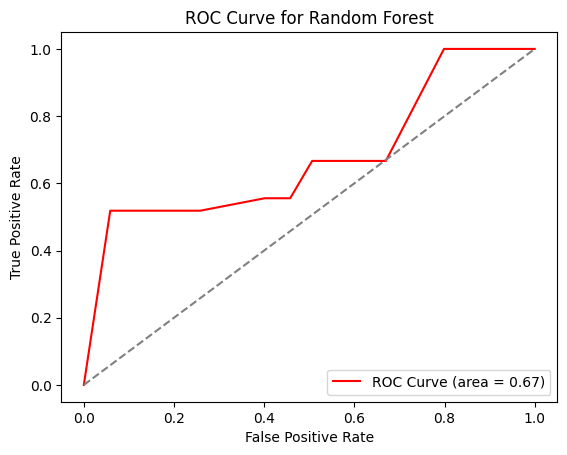

In [18]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='red', label=f'ROC Curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


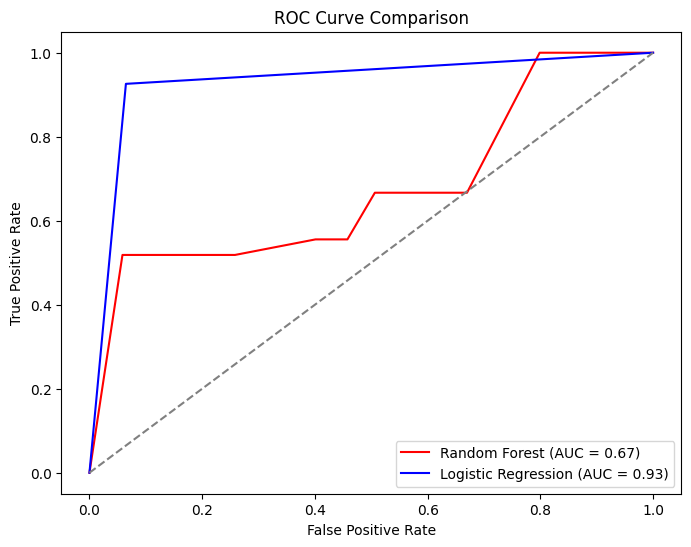

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and AUC for Logistic Regression
fpr_other, tpr_other, thresholds_other = roc_curve(y_test, best_lr.predict_proba(X_test)[:, 1])
roc_auc_other = auc(fpr_other, tpr_other)

# Plot both ROC curves in the same plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='red', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_other, tpr_other, color='blue', label=f'Logistic Regression (AUC = {roc_auc_other:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()